In [1]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [26]:
import albumentations as alb

In [27]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [28]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='LeftEye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='RightEye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='LeftEye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='RightEye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['LeftEye','RightEye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'LeftEye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'RightEye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

KeyboardInterrupt: 

In [3]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [4]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [5]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

In [6]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [7]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [8]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [9]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
print(len(train_images), len(test_images), len(val_images))

10320 2280 2280


In [11]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(11000)
train = train.batch(16)
train = train.prefetch(4)

In [12]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3000)
test = test.batch(16)
test = test.prefetch(4)

In [13]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(3000)
val = val.batch(16)
val = val.prefetch(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


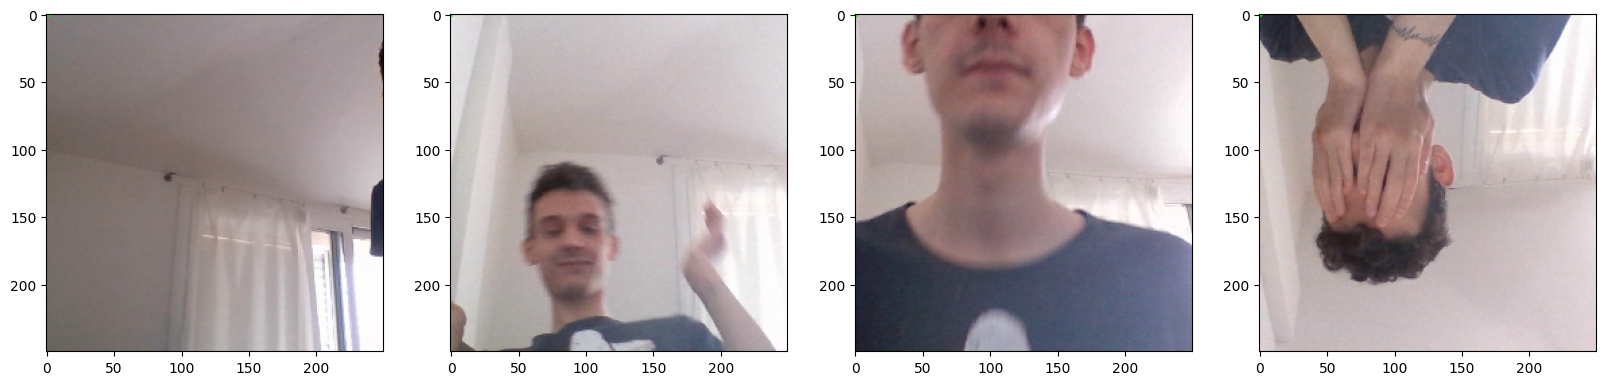

In [ ]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [15]:
model = Sequential()

model.add(Input(shape=(250,250,3)))
model.add(ResNet152V2(include_top=False, input_shape=(250,250,3)))
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, 2, padding='same', activation='relu'))
model.add(Conv2D(256, 2, 2, activation='relu'))
model.add(Dropout(0.05))
model.add(Conv2D(4, 2, 2))
model.add(Reshape((4,)))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 256)     295168    
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        36896     
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                        

In [17]:
batches_per_epoch = len(train)
lr_decay = 0.0007
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=batches_per_epoch,
    decay_rate=lr_decay)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.MeanSquaredError()

In [19]:
model.compile(optimizer=optimizer, loss=loss)

In [20]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(16, 250, 250, 3)

In [20]:
hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5


  9/645 [..............................] - ETA: 3:36:10 - loss: 0.1171

KeyboardInterrupt: 

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [ ]:
yhat = model.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)